<a href="https://colab.research.google.com/github/g-roger/deep-learning/blob/master/03_PSE_Demo3_RNN_SpamFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Power Skill Extensions - Leading Technology Transformation - Applied Machine Learning - Recurrent Neural Networks (RNNs)

##Exercício de fixação IV - Recurrent Neural Networks usando Keras e a base SMS Spam Collection Data (mensagens spam rotuladas)

### Profs. Ahirton Lopes, Felipe Teodoro e Vinicius Soares

In [ ]:
from keras.layers import SimpleRNN, LSTM, GRU, Embedding, Dense, Flatten
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def message_to_array(msg):
    msg = msg.lower().split(' ')
    test_seq = np.array([word_index[word] for word in msg])

    test_seq = np.pad(test_seq, (500-len(test_seq), 0), 'constant', constant_values=(0))
    test_seq = test_seq.reshape(1, 500)
    return test_seq

### Carregando a base SMS Spam Collection Data (sms rotulados em spam e ham)

*** Mais informações em https://www.kaggle.com/uciml/sms-spam-collection-dataset e https://archive.ics.uci.edu/ml/datasets/sms+spam+collection ***

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('Arquivo de nome "{name}" de tamanho {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving spam_data.csv to spam_data.csv
Arquivo de nome "spam_data.csv" de tamanho 485703 bytes


In [ ]:
# Importando nossos dados a partir do arquivo .csv

data = pd.read_csv('spam_data.csv', sep=',')

## Pré processamento de mensagens e rótulos

In [ ]:
messages = []
labels = []

for index, row in data.iterrows():
    messages.append(row['Message'])
    if row['Category'] == 'ham': # classificando em 0 e 1
        labels.append(0)
    else:
        labels.append(1)

In [ ]:
text_data_train = np.asarray(messages)
text_data_target = np.asarray(labels)

print("Numero de mensagens: ", len(messages))
print("Numero de rotulos: ", len(labels))

Numero de mensagens:  5572
Numero de rotulos:  5572


## Verificando o formato de nossas mensagens e rótulos

In [ ]:
text_data_train[:5]

array(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
       'Ok lar... Joking wif u oni...',
       "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
       'U dun say so early hor... U c already then say...',
       "Nah I don't think he goes to usf, he lives around here though"],
      dtype='<U910')

In [ ]:
text_data_target[:5]

array([0, 0, 1, 0, 0])

## Processamento de nosso vocabulário

In [ ]:
max_vocab = 10000 # Ignorando todas as palavras, exceto as 10.000 palavras mais comuns em nosso vocabulário
max_len = 500 # max_len especifica o comprimento máximo da sequência (que é truncada se for longa, e preenchida - via padding - se mais curta)

tokenizer = Tokenizer(num_words=max_vocab)

# Calculando a frequência das palavras em nossos dados de treinamento

tokenizer.fit_on_texts(text_data_train)

# Convertendo um array de mensagens para uma lista de sequências de inteiros

sequences = tokenizer.texts_to_sequences(text_data_train)

# Criação de dicionário afim de registrar as palavras para um índice do tipo inteiro

word_index = tokenizer.word_index

# Convertendo a matriz de sequências de inteiros em uma matriz 2D (com preenchimento, quando necessário)

data = pad_sequences(sequences, maxlen=max_len)

print("data shape: ", data.shape)

data shape:  (5572, 500)


## Dividindo o dataset em treinamento e validação

In [ ]:
# Usando 80% dos dados disponíveis para treinamento e validação (80% treinamento, 20% validação), bem como 20% para teste

train_samples = int(len(text_data_train)*0.8)

messages_train = data[:train_samples]
labels_train = text_data_target[:train_samples]

messages_test = data[train_samples:len(text_data_train)-2]
labels_test = text_data_target[train_samples:len(text_data_train)-2]

embedding_mat_columns=32

## Definindo a arquitetura do modelo (IMPORTANTE!)

* 3 camadas (Camadas de Embedding, Camada RNN Simples e Densa);
* Uma última camada do tipo totalmente conectada contendo 1 neurônio.

In [ ]:
# Construindo nosso modelo de RNN Simples (via camada SimpleRNN)

model = Sequential()

# Utilização de camada de Embedding tendo em vista converter a codificação de inteiros em embeddings de palavras
# O modelo vai então aprender a partir da matriz de embedding durante o treinamento;

model.add(Embedding(input_dim=max_vocab, output_dim=embedding_mat_columns, input_length=max_len)) # A matriz de embedding contém max_vocab como número de linhas e o número de colunas escolhido

model.add(SimpleRNN(units=embedding_mat_columns))

# Após o descrito na Aula 6, testem com novas arquiteturas de camadas (RNNs, LSTMs e GRUs Bidirecionais e stackings) (!)

#model.add(LSTM(units=embedding_mat_columns))
#model.add(GRU(units=embedding_mat_columns))

model.add(Dense(1, activation='sigmoid'))

## Compilando o modelo

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


## Verificando nosso nosso modelo 

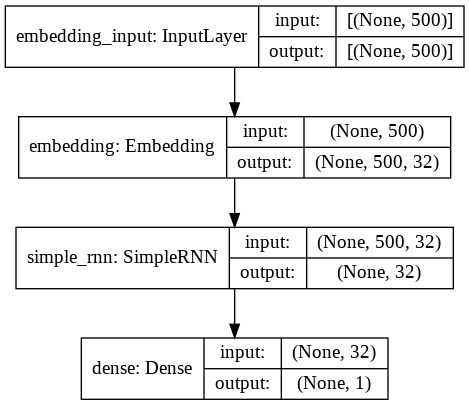

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Treinamento de nosso modelo

In [ ]:
model.fit(messages_train, labels_train, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
56/56 [==============================] - 38s 616ms/step - loss: 0.2900 - acc: 0.9001 - val_loss: 0.1153 - val_acc: 0.9641
Epoch 2/50
56/56 [==============================] - 34s 605ms/step - loss: 0.0914 - acc: 0.9736 - val_loss: 0.0813 - val_acc: 0.9765
Epoch 3/50
56/56 [==============================] - 34s 600ms/step - loss: 0.0535 - acc: 0.9837 - val_loss: 0.0547 - val_acc: 0.9832
Epoch 4/50
56/56 [==============================] - 34s 605ms/step - loss: 0.0441 - acc: 0.9868 - val_loss: 0.1066 - val_acc: 0.9652
Epoch 5/50
56/56 [==============================] - 34s 602ms/step - loss: 0.0347 - acc: 0.9893 - val_loss: 0.0565 - val_acc: 0.9843
Epoch 6/50
56/56 [==============================] - 34s 603ms/step - loss: 0.0417 - acc: 0.9837 - val_loss: 0.1270 - val_acc: 0.9518
Epoch 7/50
56/56 [==============================] - 34s 603ms/step - loss: 0.0414 - acc: 0.9868 - val_loss: 0.0796 - val_acc: 0.9787
Epoch 8/50
56/56 [==============================] - 33s 597ms/step - 

## Teste de nosso modelo

In [ ]:
prediction = model.predict(messages_test)
accuracy = model.evaluate(messages_test, labels_test)
print("Perda em teste {0:.2f} acuracia eh {1:.2f}  ".format(accuracy[0],accuracy[1]))

35/35 [==============================] - 2s 47ms/step - loss: 0.2375 - acc: 0.9757
Perda em teste 0.24 acuracia eh 0.98  


In [ ]:
# Construindo mensagem personalizada para teste rápido

#custom_msg = 'Hi how are you'
custom_msg = 'Free entry in 2 a wkly comp to win FA Cup final tkts 21st May Text FA to 87121 to receive entry question'

test_seq = message_to_array(custom_msg)
prediction = (model.predict(test_seq) > 0.5).astype("int32")
print(prediction)  #[1] para spam [0] para nao spam (ham)

[[1]]
